# Data Exploration
1. [Zeitbezogene Features hinzufügen](#1)
1. [Missing values](#2)
1. [Datensatz beschränken](#3)
1. [Betrachtung von Ausreißern](#4)
1. [Feature Importance](#5)
1. [Saisonalität und Trends](#6)
1. [Korrelation der Features](#7)

In [32]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_regression

plt.style.use('ggplot')

print("Setup complete")

Setup complete


In [33]:
df = pd.read_csv('../input/ps-ds1/ps_ds1.csv')
df.timestamp = pd.to_datetime(df.timestamp)

df.describe()

,dataid,timestamp,air1,air2,air3,airwindowunit1,aquarium1,bathroom1,bathroom2,bedroom1,...,use,construction_year,n_residents,n_rooms,total_area,outdoor_temp,app_outdoor_temp,humidity,dataid_y,indoor_temp
count,87581.000000,87581,77474.000000,8386.000000,0.0,8684.000000,0.0,25670.000000,8362.000000,34622.000000,...,87368.000000,87581.000000,87581.000000,87581.000000,78821.000000,87561.000000,87561.000000,87561.000000,0.0,0.0
mean,5344.325219,2018-07-02 10:33:06.677475840,0.474819,0.060127,NaN,0.038220,NaN,0.010393,0.001780,0.052040,...,1.448548,1997.997831,2.500108,8.199610,193.766279,20.153042,20.658318,0.700174,NaN,NaN
min,661.000000,2018-01-01 00:00:00,-0.012750,-0.018250,NaN,0.000000,NaN,-0.001000,-0.001000,-0.001000,...,0.000000,1950.000000,0.000000,4.000000,154.590000,-8.660000,-13.580000,0.130000,NaN,NaN
25%,3456.000000,2018-04-02 05:00:00,0.000250,-0.005250,NaN,0.002250,NaN,0.002000,0.000000,0.007250,...,0.543500,2006.000000,2.000000,6.000000,159.790000,13.440000,13.440000,0.540000,NaN,NaN
50%,5746.000000,2018-07-02 11:00:00,0.004000,-0.004500,NaN,0.023000,NaN,0.004250,0.000000,0.019000,...,0.995750,2007.000000,2.000000,9.000000,185.810000,21.760000,22.170000,0.740000,NaN,NaN
75%,7800.000000,2018-10-01 16:00:00,0.728750,-0.003250,NaN,0.024000,NaN,0.023750,0.001500,0.071250,...,1.943000,2008.000000,3.000000,10.000000,213.680000,26.680000,28.270000,0.880000,NaN,NaN
max,9922.000000,2018-12-31 23:00:00,4.146500,1.310250,NaN,1.303750,NaN,0.843250,0.065500,0.604750,...,14.804500,2009.000000,5.000000,11.000000,260.130000,41.990000,42.340000,1.000000,NaN,NaN
std,2907.495781,NaN,0.768621,0.189653,NaN,0.082397,NaN,0.013292,0.004697,0.069516,...,1.293153,19.729855,1.284649,2.271668,35.678789,9.227060,10.390382,0.211481,NaN,NaN


<a id="1"></a>
## 1. Zeitbezogene Features hinzufügen

In [34]:
df['hour'] = df.timestamp.dt.hour
df['wday'] = df.timestamp.dt.dayofweek  # 0 = Montag, 6 = Sonntag
df['day'] = df.timestamp.dt.day
df['month'] = df.timestamp.dt.month
df['is_off_day'] = (df.is_holiday | df.wday.isin([5, 6]))

df.sample(5)

,dataid,timestamp,air1,air2,air3,airwindowunit1,aquarium1,bathroom1,bathroom2,bedroom1,...,app_outdoor_temp,humidity,dataid_y,indoor_temp,is_holiday,hour,wday,day,month,is_off_day
14751,1642,2018-09-07 15:00:00,1.13600,NaN,NaN,NaN,NaN,0.001,NaN,NaN,...,32.96,0.70,NaN,NaN,False,15,4,7,9,False
30023,4031,2018-06-05 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07725,...,31.91,0.58,NaN,NaN,False,23,1,5,6,False
35864,4767,2018-02-04 08:00:00,-0.00500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.31,0.98,NaN,NaN,False,8,6,4,2,True
74376,9278,2018-06-29 19:00:00,2.86875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.21,0.45,NaN,NaN,False,19,4,29,6,False
25776,3456,2018-12-11 00:00:00,0.00000,NaN,NaN,NaN,NaN,0.024,NaN,0.00900,...,2.10,0.85,NaN,NaN,False,0,1,11,12,False


<a id="2"></a>
## 2. Missing values
https://www.kaggle.com/code/alexisbcook/missing-values

In [35]:
# Spalten entfernen, in denen jeder Wert identisch ist
cols_to_drop = [col for col in df.columns if df[col].nunique() <= 1]
df.drop(cols_to_drop, axis=1, inplace=True)

# Prozentsatz der fehlenden Werte für jede Spalte
missing_share = df.isnull().mean() * 100
sorted_missing_share = missing_share.sort_values(ascending=False)

max_column_name_len = max(len(column) for column in df.columns)

for column_name, percent_val in sorted_missing_share.items():
    if percent_val > 0:
        print(f"{column_name.ljust(max_column_name_len)}\t{percent_val:.2f}%")

oven2               	99.99%
outsidelights_plugs1	90.45%
bathroom2           	90.45%
air2                	90.42%
kitchen2            	90.42%
lights_plugs4       	90.09%
airwindowunit1      	90.08%
bedroom3            	90.01%
garage1             	90.01%
furnace2            	89.99%
utilityroom1        	80.87%
kitchen1            	80.45%
venthood1           	80.45%
bedroom2            	80.10%
refrigerator2       	80.09%
range1              	80.05%
bathroom1           	70.69%
dryg1               	70.54%
office1             	70.09%
livingroom1         	60.96%
bedroom1            	60.47%
car1                	60.28%
lights_plugs3       	60.12%
kitchenapp2         	50.78%
disposal1           	50.25%
oven1               	40.94%
lights_plugs2       	40.16%
kitchenapp1         	30.80%
lights_plugs1       	30.15%
refrigerator1       	20.81%
microwave1          	20.80%
drye1               	20.34%
air1                	11.54%
clotheswasher1      	10.82%
total_area          	10.00%
furnace1            

Was auffällt: Da es z.T. mehrere Badezimmer, Schlafzimmer, usw. gibt, entsteht die Problematik, dass die Spalten für die Werte z.B. eines 2. oder 3. Schlafzimmers bei den meisten Häusern leer sind, da nicht vorhanden. Um dies zu umgehen, werden die Spalten im Folgenden jeweils zusammengefasst

In [36]:
# Identifizieren der Spaltenpaare
spaltenpaare = {}
for spalte in df.columns:
    if spalte[-1].isdigit():
        basisname = spalte[:-1]
        if basisname in spaltenpaare:
            spaltenpaare[basisname].append(spalte)
        else:
            spaltenpaare[basisname] = [spalte]

# Zusammenfassen der Spalten und Erstellen neuer Spalten
for basisname, spalten in spaltenpaare.items():
    df[basisname] = df[spalten].sum(axis=1, skipna=True, min_count=1)

# Entfernen der ursprünglichen Spalten
for spalten in spaltenpaare.values():
    df.drop(columns=spalten, inplace=True)

<a id="3"></a>
## 3. Datensatz beschränken
Beschränkung auf das Haus mit den meisten Features und Datenpunkten

Gründe für die Beschränkung:
* Datensatz ist zu groß für die zur Verfügung stehende Rechenleistung
    * CPU: Intel Pentium G4560
    * GPU: NVIDIA GeForce GTX 1050 Ti
    * RAM: 8 GB
* Da man den stündlichen Verbrauch für ein bestimmtes Haus vorhersagen will, bringt es für diesen Use Case nichts andere Häuser zu betrachten

In [37]:
# Funktion, um die Anzahl der Features und Datenpunkte zu zählen
def count_info(group):
    n_features = group.notnull().any().sum()
    n_rows = len(group)
    return pd.Series({'n_features': n_features, 'n_rows': n_rows})

# Gruppieren nach 'dataid' und Anwenden der Funktion auf jede Gruppe und sortieren
group_info = df.groupby('dataid').apply(count_info).sort_values(by=['n_features', 'n_rows'], ascending=[False, False])
best_id = group_info.index[0]

group_info

,n_features,n_rows
dataid,,
1642,31,8760
3456,30,8760
6139,30,8760
5746,29,8760
7800,28,8760
9922,28,8760
661,27,8760
4031,27,8760
9278,26,8760


In [38]:
# Zeilen auswählen
df = df[df.dataid == best_id]

# Spalten entfernen, in denen jeder Wert identisch ist
cols_to_drop = [col for col in df.columns if df[col].nunique() <= 1]
df.drop(cols_to_drop, axis=1, inplace=True)

# Prozentsatz der fehlenden Werte für jede Spalte
missing_share = df.isnull().mean() * 100
sorted_missing_share = missing_share.sort_values(ascending=False)

max_column_name_len = max(len(column) for column in df.columns)

for column_name, percent_val in sorted_missing_share.items():
    if percent_val > 0:
        print(f"{column_name.ljust(max_column_name_len)}\t{percent_val:.2f}%")

venthood        	4.45%
clotheswasher   	4.45%
utilityroom     	4.45%
refrigerator    	4.45%
microwave       	4.45%
livingroom      	4.45%
kitchenapp      	4.45%
furnace         	4.45%
dryg            	4.45%
dishwasher      	4.45%
bathroom        	4.45%
oven            	1.63%
drye            	1.63%
car             	1.63%
air             	1.63%
use             	1.12%
humidity        	0.02%
app_outdoor_temp	0.02%
outdoor_temp    	0.02%


<a id="4"></a>
## 4. Betrachtung von Ausreißern

In [39]:
df.min()

timestamp           2018-01-01 00:00:00
use                                 0.0
outdoor_temp                      -8.66
app_outdoor_temp                 -13.58
humidity                           0.13
is_holiday                        False
hour                                  0
wday                                  0
day                                   1
month                                 1
is_off_day                        False
air                                 0.0
bathroom                         -0.001
car                            -0.00875
clotheswasher                  -0.00275
dishwasher                          0.0
drye                           -0.00575
dryg                            -0.0005
furnace                          0.0065
kitchenapp                     -1.48575
livingroom                        0.028
microwave                       0.00175
oven                              0.007
refrigerator                      0.011
utilityroom                    -0.21375


### Warum ist der Stromverbrauch teilweise negativ

Ein negativer Stromverbrauch bei Haushaltsgeräten ist ungewöhnlich und kann auf verschiedene Ursachen hinweisen. Hier sind einige mögliche Erklärungen:

1. Fehler in der Messung: Dies ist die wahrscheinlichste Ursache. Messfehler können durch defekte oder falsch kalibrierte Messgeräte, schlechte Verbindungen oder andere technische Probleme entstehen.
2. Rückeinspeisung ins Netz: In Haushalten mit Solaranlagen oder anderen Formen der Energieerzeugung kann es vorkommen, dass Energie ins Netz zurückgespeist wird. Wenn das Messgerät nicht korrekt zwischen verbrauchter und erzeugter Energie unterscheidet, könnte dies als negativer Verbrauch angezeigt werden.
3. Software- oder Anzeigefehler: Manchmal können Softwareprobleme oder Anzeigefehler in digitalen Messsystemen zu falschen Werten führen.
4. Netzbedingte Schwankungen: In seltenen Fällen können Schwankungen im Stromnetz zu ungewöhnlichen Messwerten führen.

Da die Werte nur minimal negativ sind, handelt es sich vermutlich um einen Messfehler

In [40]:
appliances = ['air', 'bathroom', 'car', 'clotheswasher', 'dishwasher', 'drye', 'dryg', 'furnace','kitchenapp',
              'livingroom', 'microwave', 'oven', 'refrigerator', 'utilityroom', 'venthood']

# Werte, die negativ sind, auf 0 setzen
for column in appliances:
    df[column] = df[column].apply(lambda x: 0 if x < 0 else x)

df.min()

timestamp           2018-01-01 00:00:00
use                                 0.0
outdoor_temp                      -8.66
app_outdoor_temp                 -13.58
humidity                           0.13
is_holiday                        False
hour                                  0
wday                                  0
day                                   1
month                                 1
is_off_day                        False
air                                 0.0
bathroom                            0.0
car                                 0.0
clotheswasher                       0.0
dishwasher                          0.0
drye                                0.0
dryg                                0.0
furnace                          0.0065
kitchenapp                          0.0
livingroom                        0.028
microwave                       0.00175
oven                              0.007
refrigerator                      0.011
utilityroom                         0.0


In [41]:
df.max()

timestamp           2018-12-31 23:00:00
use                              9.2035
outdoor_temp                      41.99
app_outdoor_temp                  42.34
humidity                            1.0
is_holiday                         True
hour                                 23
wday                                  6
day                                  31
month                                12
is_off_day                         True
air                              2.8165
bathroom                          0.093
car                             3.39625
clotheswasher                     0.306
dishwasher                      0.89925
drye                              0.003
dryg                              0.572
furnace                         0.72275
kitchenapp                      0.78925
livingroom                      0.98525
microwave                         0.555
oven                             1.8565
refrigerator                    0.22225
utilityroom                     0.00275


### Der maximale Stromverbrauch für das gesamte Haus (`use`) wirkt sehr hoch

In [42]:
df = df.sort_values(by='timestamp').reset_index(drop=True)

max_indices = df.nlargest(5, 'use').index
max_idx = max_indices[2]

start_idx = max_idx - 3
end_idx = max_idx + 4

cols_to_show = appliances + ['use', 'hour']
df[cols_to_show][start_idx:end_idx]

,air,bathroom,car,clotheswasher,dishwasher,drye,dryg,furnace,kitchenapp,livingroom,microwave,oven,refrigerator,utilityroom,venthood,use,hour
4215,0.87475,0.00100,0.00400,0.00025,0.00100,0.0,0.08600,0.47425,0.00175,0.08375,0.06200,0.00825,0.15125,0.0,0.00000,1.84775,15
4216,1.00700,0.00075,0.00350,0.27750,0.00075,0.0,0.00050,0.42050,0.00150,0.46525,0.00325,0.00825,0.20650,0.0,0.01175,2.55050,16
4217,1.56800,0.00075,0.08800,0.12500,0.00075,0.0,0.00175,0.50800,0.00000,0.55225,0.00250,0.00775,0.15700,0.0,0.02800,4.16850,17
4218,2.51275,0.00050,3.38075,0.00050,0.00100,0.0,0.00200,0.65825,0.00000,0.39600,0.20325,0.00800,0.15900,0.0,0.02900,8.78775,18
4219,2.46600,0.00100,3.37500,0.06950,0.00100,0.0,0.00000,0.65650,0.00225,0.17500,0.11150,0.00850,0.15475,0.0,0.00000,7.21350,19
4220,2.40200,0.00100,3.33325,0.00000,0.00100,0.0,0.04375,0.66175,0.00200,0.38575,0.00325,0.00825,0.14825,0.0,0.00300,7.18675,20
4221,2.11025,0.00250,0.10025,0.13275,0.00100,0.0,0.07825,0.63175,0.00200,0.35000,0.00325,0.00825,0.14100,0.0,0.00000,3.78125,21


Der beobachtete maximale Wert für den Stromverbrauch stellt keinen Ausreißer oder Messfehler dar. Vielmehr lässt sich diese Spitze im Stromverbrauch durch alltägliche Verhaltensmuster erklären. Typischerweise steigt der Stromverbrauch in Haushalten zu Zeiten an, wenn Menschen von der Arbeit nach Hause kommen. Dies ist oft am späten Nachmittag oder frühen Abend der Fall.

Die Zunahme des Stromverbrauchs korreliert mit alltäglichen Aktivitäten wie dem Einschalten von Lichtern, Haushaltsgeräten und Unterhaltungselektronik. Zusätzlich kann die Nutzung von Heiz- oder Kühlgeräten, abhängig von der Jahreszeit, zu diesem Zeitpunkt ebenfalls ansteigen.

Ein weiteres Indiz dafür, dass es sich bei den Spitzenwerten nicht um Messfehler handelt, ist das erkennbare Muster im Verbrauch: ein Anstieg kurz vor dem Maximum und ein Abfall danach. Diese beobachteten Muster spiegeln typische Verhaltensweisen und Gewohnheiten im Haushaltsstromverbrauch wider und bestätigen die Plausibilität der gemessenen Werte.

Größter Faktor: Auto --> E-Auto, das geladen wird, wenn Bewohner nach Hause kommen, und nach 3 Stunden voll geladen ist

<a id="5"></a>
## 5. Feature Importance
### Mutual Information
https://www.kaggle.com/code/ryanholbrook/mutual-information

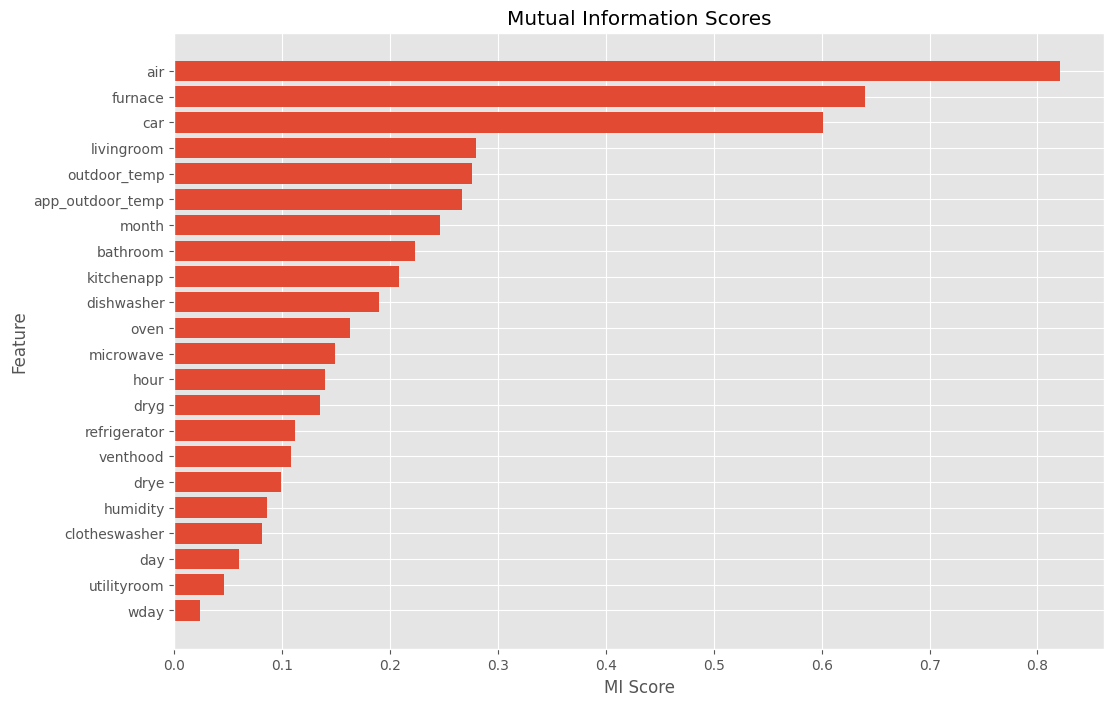

In [43]:
# Vorläufige Auffüllung durch Imputation, aber nicht auf den gespeicherten Datensatz, um Data Leakage zu verhindern
# imputed_df = df.bfill().fillna(method='ffill')
imputed_df = df.copy()
simple_imputer = SimpleImputer(strategy='mean')
selected_columns = missing_share[missing_share > 0].index.tolist()
imputed_df[selected_columns] = simple_imputer.fit_transform(imputed_df[selected_columns])

y = imputed_df.use
X = imputed_df.drop(['timestamp', 'use', 'is_holiday', 'is_off_day'], axis=1)

mi_values = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_values, index=X.columns).sort_values(ascending=True)

width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)
plt.figure(figsize=(12, 8))
plt.barh(width, mi_scores)
plt.xlabel('MI Score')
plt.ylabel('Feature')
plt.yticks(width, ticks)
plt.title("Mutual Information Scores")
plt.show()

In [44]:
imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   timestamp         8760 non-null   datetime64[ns]
 1   use               8760 non-null   float64       
 2   outdoor_temp      8760 non-null   float64       
 3   app_outdoor_temp  8760 non-null   float64       
 4   humidity          8760 non-null   float64       
 5   is_holiday        8760 non-null   bool          
 6   hour              8760 non-null   int32         
 7   wday              8760 non-null   int32         
 8   day               8760 non-null   int32         
 9   month             8760 non-null   int32         
 10  is_off_day        8760 non-null   bool          
 11  air               8760 non-null   float64       
 12  bathroom          8760 non-null   float64       
 13  car               8760 non-null   float64       
 14  clotheswasher     8760 n

<a id="6"></a>
## 6. Saisonalität und Trends

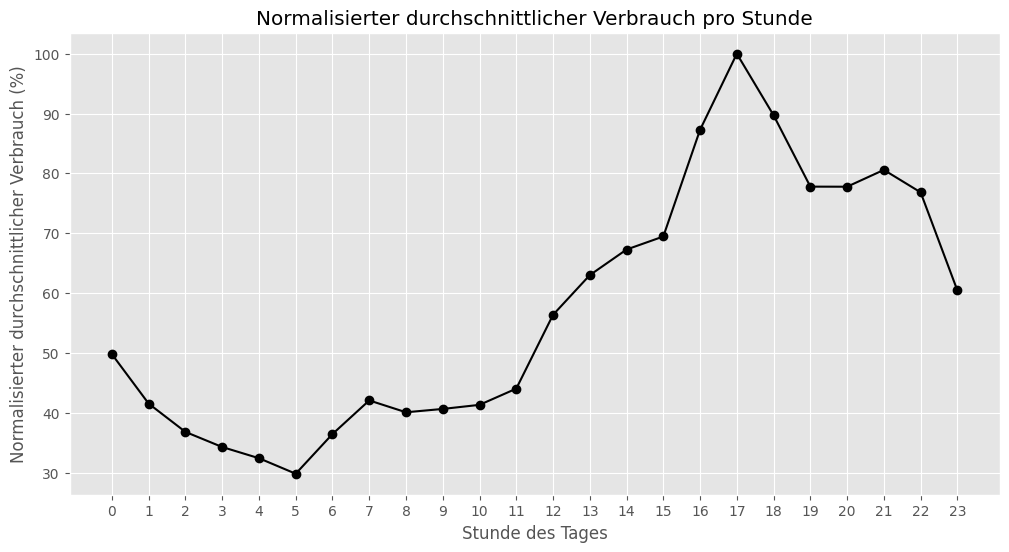

In [45]:
# Gruppieren nach Stunde und Berechnen des Durchschnitts
hourly_avg = imputed_df.groupby('hour').use.mean()

# Normalisieren der Werte auf 100%
max_value = hourly_avg.max()
hourly_avg_normalized = (hourly_avg / max_value) * 100

# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(hourly_avg_normalized.index, hourly_avg_normalized.values, color='black', marker='o')
plt.title('Normalisierter durchschnittlicher Verbrauch pro Stunde')
plt.xlabel('Stunde des Tages')
plt.ylabel('Normalisierter durchschnittlicher Verbrauch (%)')
plt.xticks(range(24))
plt.show()

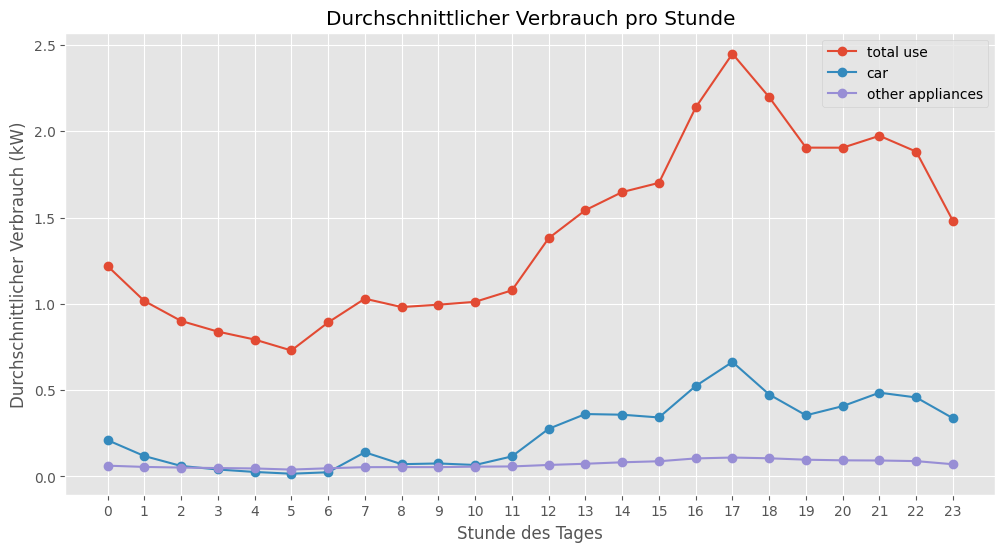

In [46]:
hourly_avg_car = imputed_df.groupby('hour').car.mean()

other_apps = [item for item in appliances if item != 'car']
hourly_avg_rest = imputed_df.groupby('hour')[other_apps].mean().mean(axis=1)

plt.figure(figsize=(12, 6))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', label='total use')
plt.plot(hourly_avg.index, hourly_avg_car.values, marker='o', label='car')
plt.plot(hourly_avg.index, hourly_avg_rest.values, marker='o', label='other appliances')
plt.title('Durchschnittlicher Verbrauch pro Stunde')
plt.xlabel('Stunde des Tages')
plt.ylabel('Durchschnittlicher Verbrauch (kW)')
plt.xticks(range(24))
plt.legend()
plt.show()

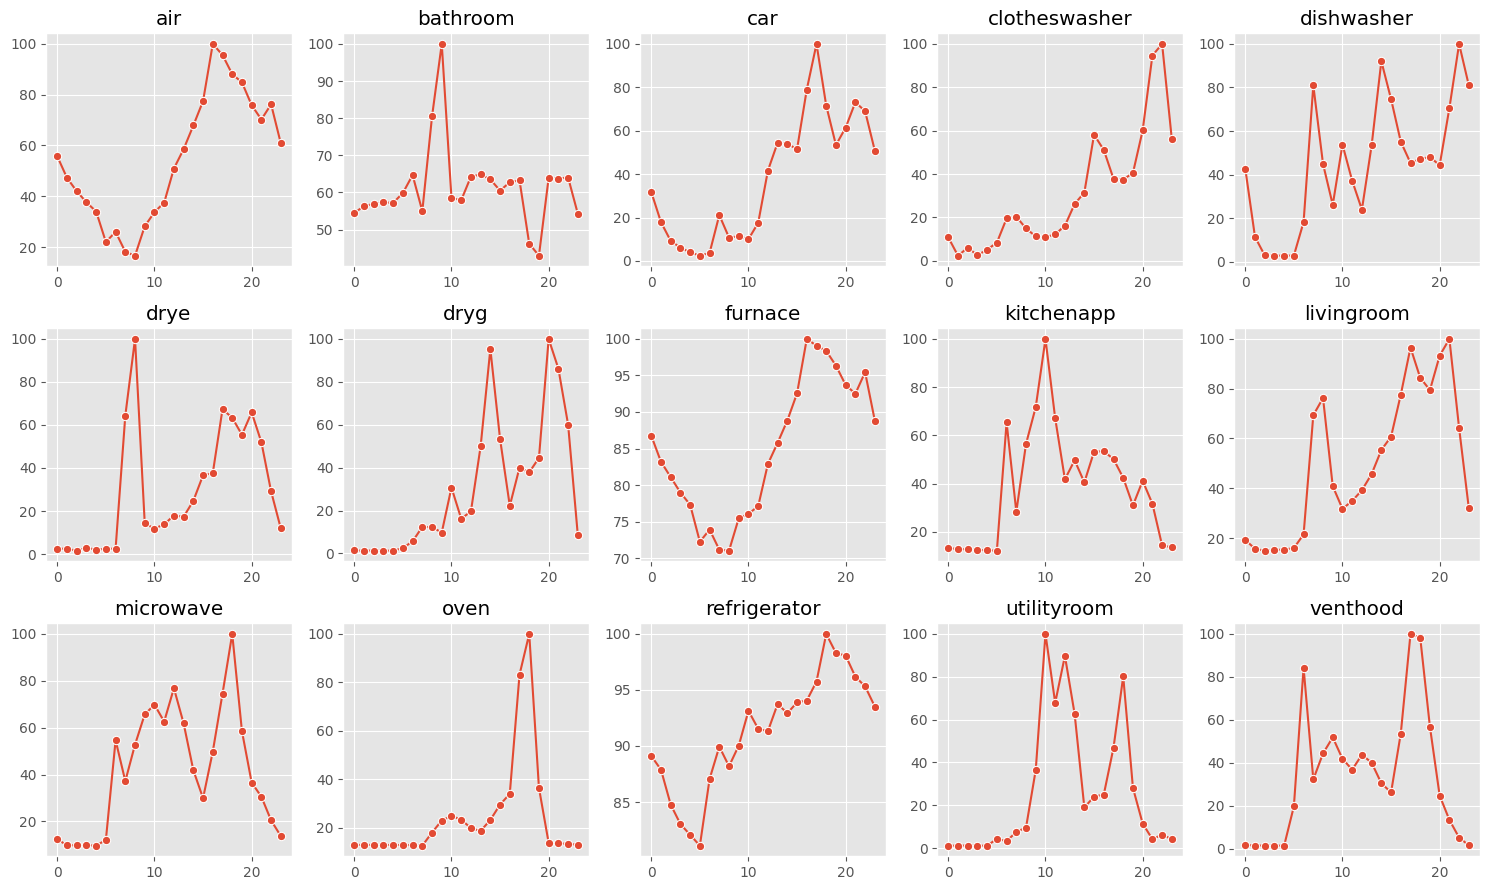

In [47]:
num_cols = 5
num_rows = 3

plt.figure(figsize=(3 * num_cols, 3 * num_rows))

for i, column in enumerate(appliances):
    plt.subplot(num_rows, num_cols, i + 1)  # Nummer der Zeilen, Nummer der Spalten, aktueller Subplot

    hourly_avg = imputed_df.groupby('hour')[column].mean()
    max_value = hourly_avg.max()
    hourly_avg_normalized = (hourly_avg / max_value) * 100
    sns.lineplot(x=hourly_avg_normalized.index, y=hourly_avg_normalized.values, marker='o')

    plt.title(column)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

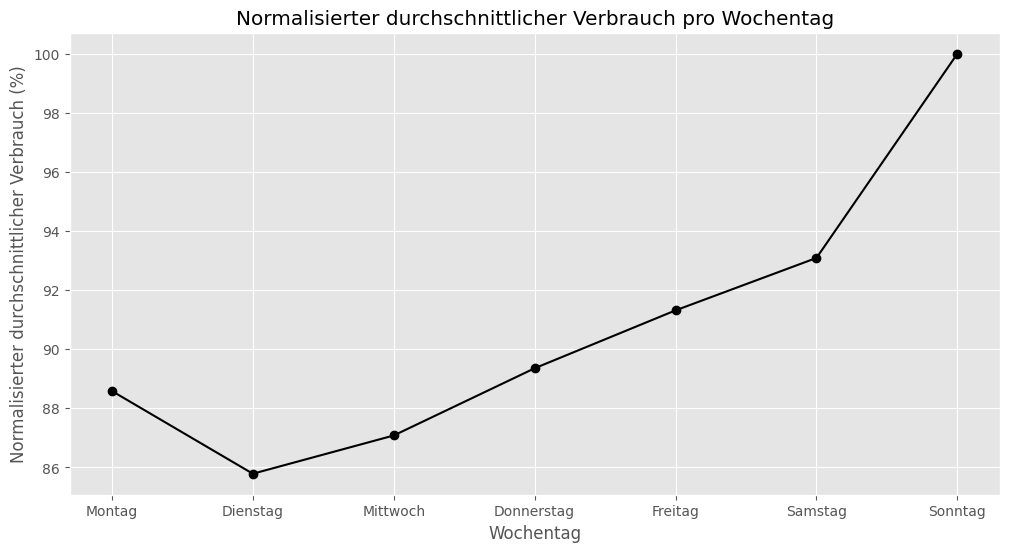

In [48]:
# Gruppieren nach Wochentag und Berechnen des Durchschnitts
weekly_avg = imputed_df.groupby('wday').use.mean()

# Normalisieren der Werte auf 100%
max_value = weekly_avg.max()
weekly_avg_normalized = (weekly_avg / max_value) * 100

# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(weekly_avg_normalized.index, weekly_avg_normalized.values, color='black', marker='o')
plt.title('Normalisierter durchschnittlicher Verbrauch pro Wochentag')
plt.xlabel('Wochentag')
plt.ylabel('Normalisierter durchschnittlicher Verbrauch (%)')
plt.xticks(range(7), ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag'])
plt.show()

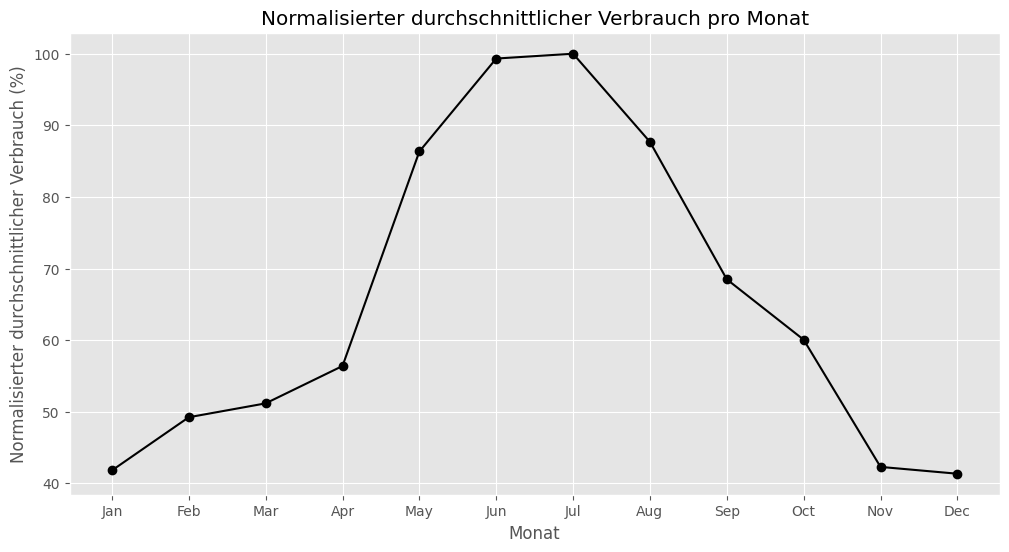

In [49]:
# Monatsabkürzungen erstellen
imputed_df['month_abbr'] = imputed_df.timestamp.dt.strftime('%b')

# Gruppieren nach Monat und Berechnen des Durchschnitts
monthly_avg = imputed_df.groupby('month').use.mean()
monthly_avg.index = imputed_df.month_abbr.unique()

# Normalisieren der Werte auf 100%
max_value = monthly_avg.max()
monthly_avg_normalized = (monthly_avg / max_value) * 100

# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg_normalized.index, monthly_avg_normalized.values, color='black', marker='o')
plt.title('Normalisierter durchschnittlicher Verbrauch pro Monat')
plt.xlabel('Monat')
plt.ylabel('Normalisierter durchschnittlicher Verbrauch (%)')
plt.show()

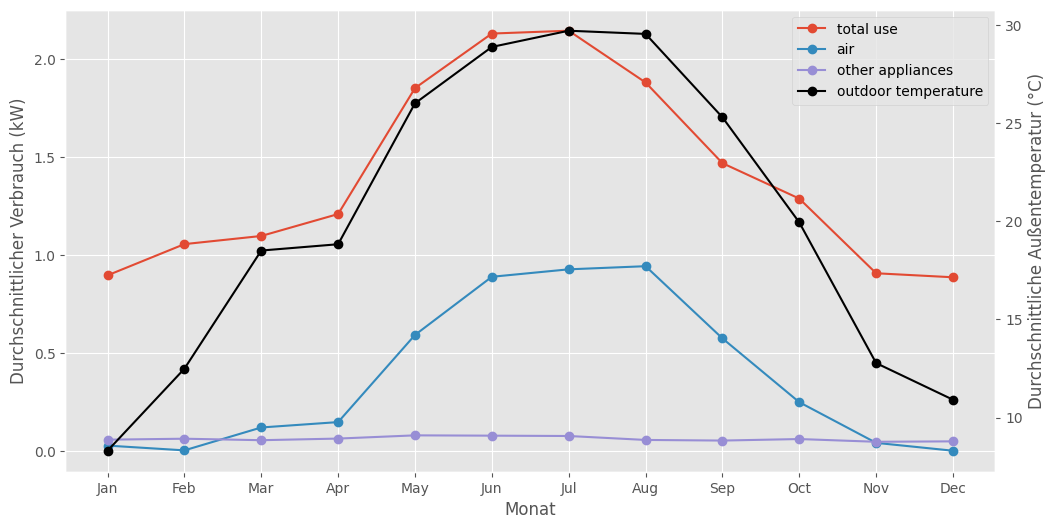

In [50]:
monthly_avg_air = imputed_df.groupby('month').air.mean()
monthly_avg_temp = imputed_df.groupby('month').outdoor_temp.mean()

other_apps = [item for item in appliances if item != 'air']
monthly_avg_rest = imputed_df.groupby('month')[other_apps].mean().mean(axis=1)

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(monthly_avg.index, monthly_avg.values, marker='o', label='total use')
ax1.plot(monthly_avg.index, monthly_avg_air.values, marker='o', label='air')
ax1.plot(monthly_avg.index, monthly_avg_rest.values, marker='o', label='other appliances')
ax1.set_xlabel('Monat')
ax1.set_ylabel('Durchschnittlicher Verbrauch (kW)')
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(monthly_avg.index, monthly_avg_temp.values, marker='o', label='outdoor temperature', color='black')
ax2.set_ylabel('Durchschnittliche Außentemperatur (°C)')
ax2.grid(False)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2)

plt.show()

<a id="7"></a>
## 7. Korrelation der Features

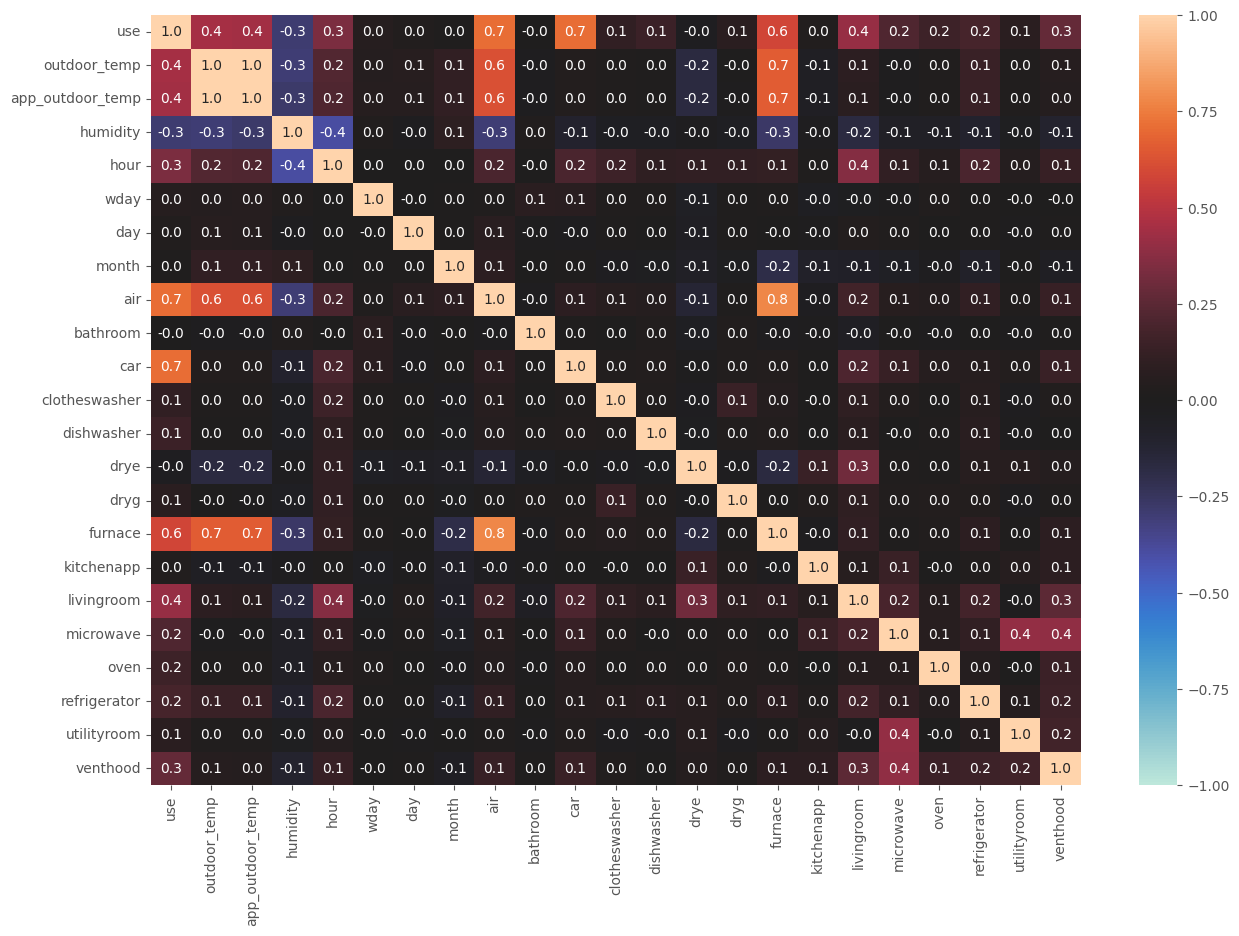

In [51]:
fig = plt.subplots(figsize=(15, 10))
corr = imputed_df.select_dtypes(include=['number']).corr()
sns.heatmap(corr, annot=True, fmt=".1f", vmin=-1.0, vmax=1.0, center=0)
plt.show()

In [52]:
# Schleife durch die Korrelationsmatrix und extrahiere Paare mit (positiver oder negativer) Korrelation >= 0,8
threshold = 0.7
correlation_pairs = []

for i in range(len(corr.columns)):
    for j in range(i + 1, len(corr.columns)):
        if abs(corr.iloc[i, j]) >= threshold:
            feature1 = corr.columns[i]
            feature2 = corr.columns[j]
            correlation_value = corr.iloc[i, j]
            correlation_pairs.append(f"{feature1} - {feature2}: {correlation_value:.1f}")

# Ausgabe der gefundenen Paare
for pair in correlation_pairs:
    print(pair)

use - air: 0.7
use - car: 0.7
outdoor_temp - app_outdoor_temp: 1.0
air - furnace: 0.8


Hier sind Erklärungen für die jeweiligen Korrelationen basierend auf realen Weltbeispielen und plausiblen Annahmen:

1. `use - air: 0.7`
   - Begründung: Diese Korrelation könnte darauf hindeuten, dass der Energieverbrauch in Haushalten (`use`) tendenziell mit der Nutzung von Klimaanlagen (`air`) zusammenhängt. Ein höherer Energieverbrauch könnte auf eine intensivere Nutzung von Klimaanlagen hinweisen, insbesondere in wärmeren Perioden.

2. `use - car: 0.7`
   - Begründung: Die Korrelation zwischen dem Energieverbrauch (`use`) und der Anzahl der Autos (`car`) könnte darauf hinweisen, dass Haushalte mit mehr Autos tendenziell auch mehr Energie verbrauchen. Dies könnte auf längere Fahrten oder eine größere Abhängigkeit von Fahrzeugen für den täglichen Bedarf hinweisen.

3. `outdoor_temp - app_outdoor_temp: 1.0`
   - Begründung: Diese perfekte positive Korrelation deutet darauf hin, dass `app_outdoor_temp` und `outdoor_temp` identische oder sehr eng miteinander verknüpfte Messungen sind, möglicherweise durch direkte Ableitung oder sehr genaue Schätzungen der Außentemperatur.

6. `air - furnace: 0.8`
   - Begründung: Die fortbestehende hohe Korrelation zwischen Klimaanlagen (`air`) und Heizungen (`furnace`) deutet darauf hin, dass Haushalte, die intensiv Klimaanlagen nutzen, auch dazu neigen, ihre Heizungen intensiv zu nutzen. Dies könnte auf eine generelle Präferenz für die aktive Regulierung der Innentemperatur hinweisen, unabhängig von der Jahreszeit.

In [53]:
# Als csv-Datei speichern
df.to_csv('ps_ds2.csv', index=False)